BAMRUNG Premchanok 
HUSTACHE Thomas 
VALDOM Janvier 2021



# Tutorial 3 - Boosting Search via Symmetry Breaking, Implied Constraints, Randomisation, and Restarts 

**Important:** Please do not read untill you fully finish the first 2 tutorials.

Congratulations! You are now level one constraint programmer: you know the basics on how to model a problem, how to display solutions, how to evaluate models, and how to choose a good branching strategy! **I'm so proud of you!**

In this tutorial we slowly dive into advanced techniques. We also start to use arithmetic constraints and solve optimisation problems.

In [ ]:
from config import setup
setup()

In [2]:
from docplex.cp.config import context
context.solver.agent = 'local'
context.solver.local.execfile = '/home/prembamrung/ibm/ILOG/CPLEX_Studio129/cpoptimizer/bin/x86-64_linux/cpoptimizer'

# 1. Golomb ruler

Your goal is to place $N$ marks on a ruler, such that no two marks are at the same distance and the total length of the ruler (the position of the last mark) is minimized. 

<div class="row" style="margin-top: 10px">
    <img src="display/images/Golomb_Ruler-4.svg" style="display: block; margin: auto; width: 400px;" />
    <p style="margin: auto; margin-top: 10px; text-align: center;">Golomb ruler of order 4 and length 6. This ruler is both optimal and perfect.</p>
</div>

Golomb ruler can be used in information theory to design error correcting codes or in telecommunications to avoid interferences during radio communications. You can read about it here: https://en.wikipedia.org/wiki/Golomb_ruler

<div class="alert alert-block alert-danger">
    
In the rest of this tutorial (except the last part), please use the following parameter when solving your model:

```python
SearchType= "DepthFirst"
```
    
</div>

In order to control the level of filtering (arc consistency, bound consistency, forward checking, etc), CPoptimizer uses a parameter called [`DefaultInferenceLevel`](http://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.parameters.py.html?highlight=defaultinferencelevel#docplex.cp.parameters.CpoParameters.DefaultInferenceLevel).

In the rest of this tutorial, you are required to test all three possibilities:

```python
DefaultInferenceLevel=Low
DefaultInferenceLevel=Medium
DefaultInferenceLevel=Extended
```

<div class="alert alert-block alert-info">

After a while, if you see one that you particularly find efficient (runtime), you can use it for the rest of the tutorial.
    
</div>

We are going to create a model for the decision version of this problem, that is, given $n$ marks, and a ruler of size $m$, place the $n$ markers such that no two markers are at the same distance.

You are free to use any constraint you want. However, you must declare and use the minimum ammount of constraints (**NOT A SINGLE UNNESSASARY CONSTRAINT**).

<div class="alert alert-block alert-success">
    
Note that for N marks, a ruler of length $2 ^ {N -1}$ can be found (I let you figure out why).
    
</div>

**Exercice:** Write a funtion `decision_model(n, m)` that builds and returns the corresponding model. 

In [3]:
from docplex.cp.model import CpoModel
from itertools import combinations
from docplex.cp.modeler import abs_of, all_diff


def decision_model(n: int, m: int) -> CpoModel:

    mdl = CpoModel(name='Golomb Ruler')
    # each variable corresponds to the position of the mark on the ruler
    marks = mdl.integer_var_list(n, 0, m, 'mark')

    # all the distances must be different
    mdl.add(mdl.all_diff([abs_of(mark[0]-mark[1])
                          for mark in list(combinations(marks, 2))]))

    return mdl

**Exercice:** Solve the problem for $n=4$ and $m=6$. Then try different values of $n$ and $m$ (but do not waste too much time). 

<div class="alert alert-block alert-info">

You can display the solution using:
    
```python
from display import golomb as display_golomb

# marks is the list of variables
display_golomb([sol[m] for m in marks])
```
    
</div>

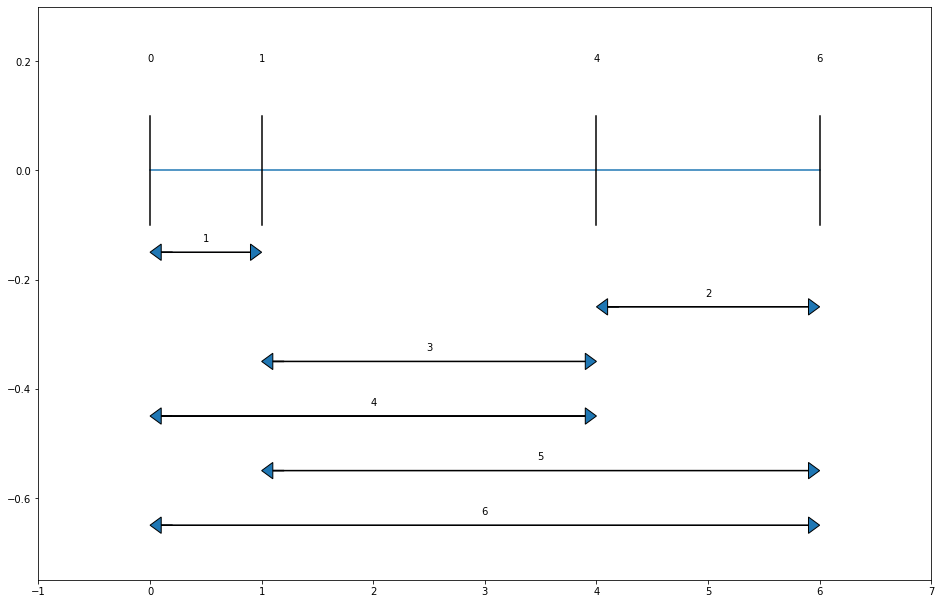

In [4]:
from display import golomb as display_golomb
mdl = decision_model(4, 6)
sol = mdl.solve(SearchType="DepthFirst")
marks = mdl.get_all_variables()
display_golomb([sol[m] for m in marks])

**Exercice:** Print and display all the sulutions for $(n, m) = (4, 6)$ and $(4,7)$.

In [5]:
for i in range(6, 8):
    print('n:', i)
    lsols = decision_model(4, i).start_search(SearchType="DepthFirst")
    nb_solutions = 0
    for sol in lsols:
        sol.write()
        nb_solutions += 1
    print('n: ', i, " ", nb_solutions)

n: 6
-------------------------------------------------------------------------------
Model constraints: 1, variables: integer: 4, interval: 0, sequence: 0
Solve status: Feasible, Fail status: SearchHasNotFailed
Search status: SearchOngoing, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------

mark_0: 0
mark_1: 6
mark_2: 4
mark_3: 1
-------------------------------------------------------------------------------
Model constraints: 1, variables: integer: 4, interval: 0, sequence: 0
Solve status: Feasible, Fail status: SearchHasNotFailed
Search status: SearchOngoing, stop cause: SearchHasNotBeenStopped
Solve time: 0.0 sec
-------------------------------------------------------------------------------

mark_0: 0
mark_1: 4
mark_2: 6
mark_3: 1
-------------------------------------------------------------------------------
Model constraints: 1, variables: integer: 4, interval: 0, sequence: 0
Solve status: Feas

-------------------------------------------------------------------------------
Model constraints: 1, variables: integer: 4, interval: 0, sequence: 0
Solve status: Feasible, Fail status: SearchHasNotFailed
Search status: SearchOngoing, stop cause: SearchHasNotBeenStopped
Solve time: 0.0 sec
-------------------------------------------------------------------------------

mark_0: 2
mark_1: 7
mark_2: 0
mark_3: 3
-------------------------------------------------------------------------------
Model constraints: 1, variables: integer: 4, interval: 0, sequence: 0
Solve status: Feasible, Fail status: SearchHasNotFailed
Search status: SearchOngoing, stop cause: SearchHasNotBeenStopped
Solve time: 0.0 sec
-------------------------------------------------------------------------------

mark_0: 2
mark_1: 0
mark_2: 6
mark_3: 5
-------------------------------------------------------------------------------
Model constraints: 1, variables: integer: 4, interval: 0, sequence: 0
Solve status: Feasible, 

**Exercice:** Write a funtion `basic_optimisation_model(n)` that builds and returns the corresponding model for the
optimisation problem. Note that an optimisation function can be seen as a variable. In order to specify the variable to optimise, we can simply use: 

```python
model.add(model.minimize(myvariable))
```

or 

```python
model.add(model.maximize(myvariable))
```


In [6]:
def basic_optimisation_model(n: int) -> CpoModel:

    mdl = CpoModel(name='basic_optimisation')
    marks = mdl.integer_var_list(n, 0, 2**(n-1), 'mark')
    mdl.add(mdl.all_diff([abs_of(mark[0]-mark[1])
                          for mark in list(combinations(marks, 2))]))
    # the objective is to minimise the length of the ruler, hence the following line:
    mdl.add(mdl.minimize(mdl.max(marks)))

    return mdl

**Exercice:** Solve the optimisation problem for $n = 6, \ldots{}, 10$  and display the solutions.

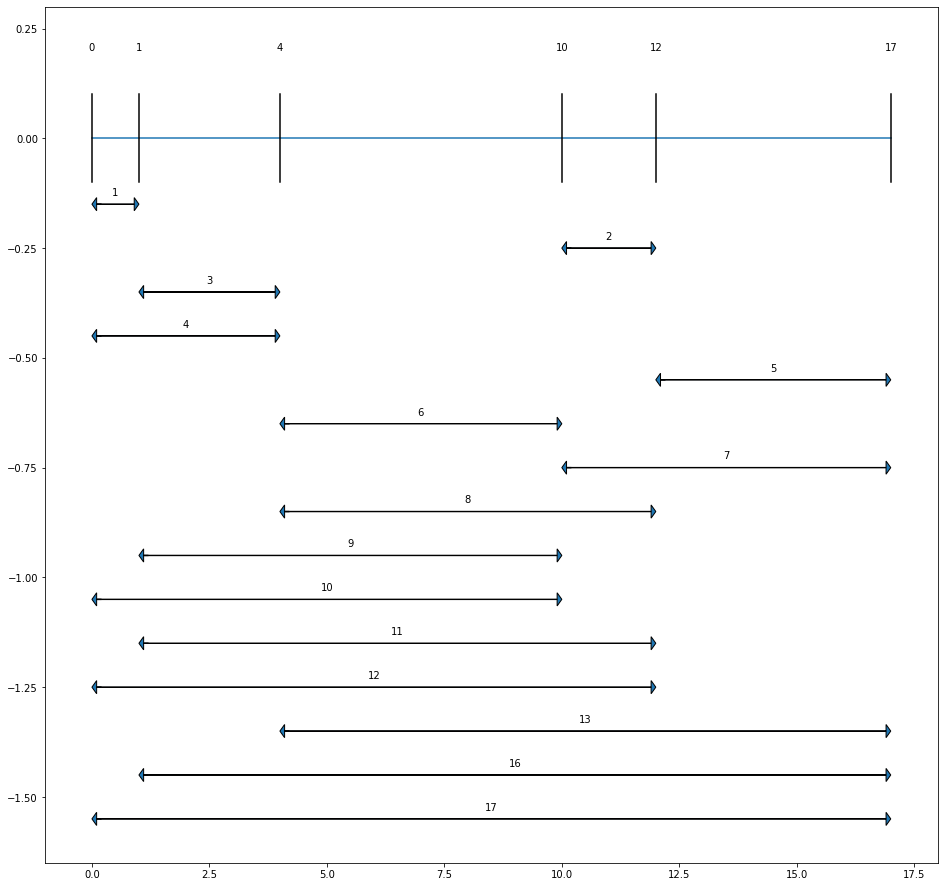

In [7]:
mdl = basic_optimisation_model(6)
sol = mdl.solve(SearchType="DepthFirst")
marks = mdl.get_all_variables()
display_golomb([sol[m] for m in marks])

## 2. Symmetry Breaking

In combinatorial optimisation, two (partial) solutions are called symmetric if we can find a transformation from one to the other. 
Consider our golomb ruler problem. Given any solution to the marks variables, if the first mark is not at index $0$, we can always shift everything to the left to start from $0$ and still have a solution. 

Constraint programming is extremely flexible to handle symmetries since they can be declared as constraints. 

In the case of the above symmetry, we can simply add a constraint to force the first mark to be at position `0`:

```python
model.add (marks[0]==0)
```

**Exercice:** This problem has another symmetry, can you find it? In order to help you, display the solution for $n=4$ and $m=6$ for the decision problem. You should find 2 solutions that are essentially the same. Can you find the symmetry? How can we model this symmetry as a constraint? 

**Exercice:** Write a new function `nosymmetry_optimisation_model(n)` that builds a noew model that avoids the two symmetries we found so far. 

In [8]:
def nosymmetry_optimisation_model(n: int) -> CpoModel:

    mdl = CpoModel(name='nosymmetry_optimisation_model')
    marks = mdl.integer_var_list(n, 0, 2**(n-1), 'mark')

    mdl.add(marks[0] == 0)
    mdl.add(abs_of(marks[1]-marks[0]) < abs_of(marks[n-1]-marks[n-2]))

    for i in range(1, n):
        mdl.add(marks[i-1] < marks[i])

    mdl.add(mdl.all_diff([abs_of(mark[0]-mark[1])
                          for mark in list(combinations(marks, 2))]))
    mdl.add(mdl.minimize(marks[n-1]))

    return mdl

-------------------------------------------------------------------------------
Model constraints: 8, variables: integer: 6, interval: 0, sequence: 0
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (17,), bounds: (5,), gaps: (0.705882,)
mark_0: 0
mark_1: 1
mark_2: 4
mark_3: 10
mark_4: 12
mark_5: 17



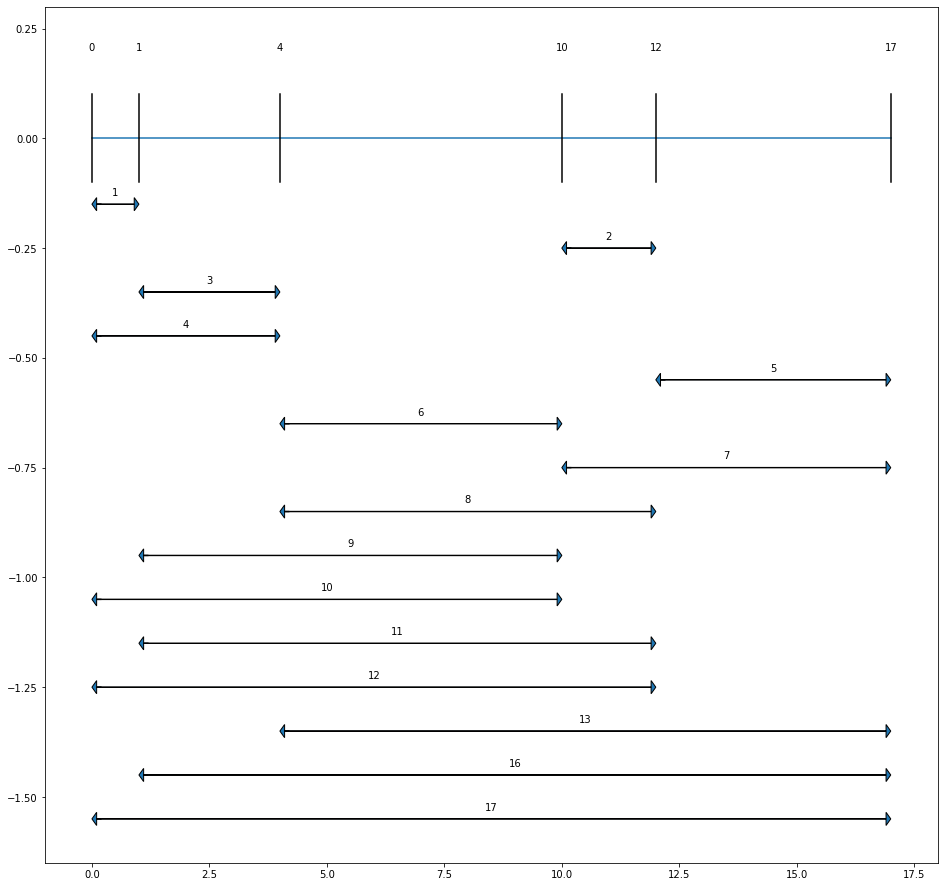

In [9]:
mdl = nosymmetry_optimisation_model(6)
sol = mdl.solve(SearchType="DepthFirst")
marks = mdl.get_all_variables()
print(sol)
display_golomb([sol[m] for m in marks])

**Exercice:** Compare `nosymmetry_optimisation_model` and `basic_optimisation_model` for different values of $n$ (you decide the values of $n$). Plot the runtime and the search tree size.

In [10]:
runtime = {'basic': [], 'nosymmetry': []}
tree_size = {'basic': [], 'nosymmetry': []}

N = [4, 5, 6]

for n in N:
    print(n)

    mdl = basic_optimisation_model(n)
    sol = mdl.solve(SearchType='DepthFirst')
    runtime['basic'] += [sol.get_solver_infos()['TotalTime']]
    tree_size['basic'] += [sol.get_solver_infos()['NumberOfChoicePoints']]

    mdl = nosymmetry_optimisation_model(n)
    sol = mdl.solve(SearchType='DepthFirst')
    runtime['nosymmetry'] += [sol.get_solver_infos()['TotalTime']]
    tree_size['nosymmetry'] += [sol.get_solver_infos()['NumberOfChoicePoints']]
    print(sol.get_solver_infos()['NumberOfChoicePoints'])

4
24
5
136
6
685


Text(0.5, 1.0, 'Tree_size')

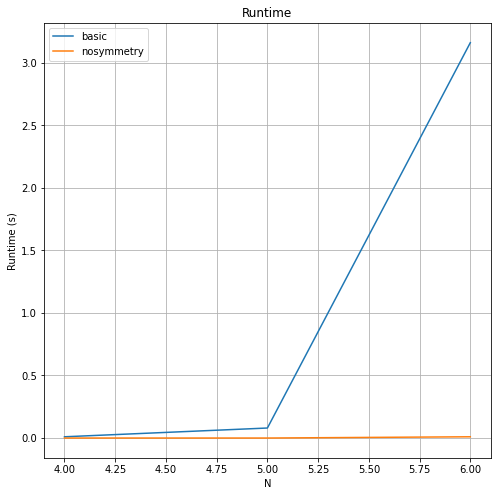

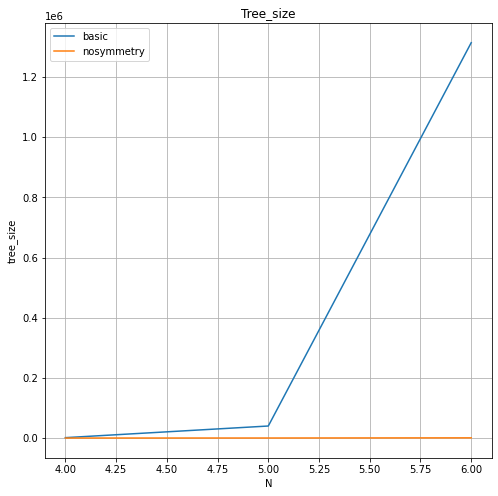

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(N, runtime['basic'], label='basic')
plt.plot(N, runtime['nosymmetry'], label='nosymmetry')
plt.legend()
plt.grid(True)
plt.xlabel('N')
plt.ylabel('Runtime (s)')
plt.title('Runtime')


plt.figure(figsize=(8, 8))
plt.plot(N, tree_size['basic'], label='basic')
plt.plot(N, tree_size['nosymmetry'], label='nosymmetry')
plt.legend()
plt.grid(True)
plt.xlabel('N')
plt.ylabel('tree_size')
plt.title('Tree_size')
#model.add (marks[0]==0)

**Question:** What is your impression about symmetries? 

Removing symmetries seems to have reduced a lot the run time and the tree sizes.

## 3. Implied Constraints

An implied constraint is one that can be dedused by looking at the original constraints of the problem. 
For instance, if we have $a<b $ and $b<c$, one can infer that $a<c$. 

Such constraints (called also redundant constraints) can help the solver to prune further the search tree. 

**Question:** In our problem there is one implied constraint. Can you find it? Please check with of the supervisors. 

<pre><code>mdl.add(all_diff(marks)) </code></pre> can be added as an implied constraint of <pre><code>mdl.add(mdl.all_diff([abs_of(mark[0]-mark[1]) for mark in list(combinations(marks,2))]))</code></pre>

**Exercice:** Write a new function `nosymmetry2_optimisation_model(n)` that adds the implied constraint to the `nosymmetry_optimisation_model(n)` and returns the new model.

In [12]:
def nosymmetry2_optimisation_model(n: int) -> CpoModel:

    mdl = CpoModel(name='nosymmetry2_optimisation_model')
    marks = mdl.integer_var_list(n, 0, 2**(n-1), 'mark')

    mdl.add(marks[0] == 0)
    mdl.add(abs_of(marks[1]-marks[0]) < abs_of(marks[n-1]-marks[n-2]))

    for i in range(1, n):
        mdl.add(marks[i-1] < marks[i])

    mdl.add(all_diff(marks))
    mdl.add(mdl.all_diff([abs_of(mark[0]-mark[1])
                          for mark in list(combinations(marks, 2))]))

    mdl.add(mdl.minimize(marks[n-1]))

    return mdl

**Exercice:** Compare `nosymmetry2_optimisation_model` and `nosymmetry_optimisation_model`. 

In [13]:
runtime = {'nosymmetry1': [], 'nosymmetry2': []}
tree_size = {'nosymmetry1': [], 'nosymmetry2': []}

N = [4, 6, 8, 10]
for n in N:
    print(n)

    mdl = nosymmetry_optimisation_model(n)
    sol = mdl.solve(SearchType='DepthFirst')
    runtime['nosymmetry1'] += [sol.get_solver_infos()['TotalTime']]
    tree_size['nosymmetry1'] += [sol.get_solver_infos()['NumberOfChoicePoints']]
    print(sol.get_solver_infos()['NumberOfChoicePoints'])

    mdl = nosymmetry2_optimisation_model(n)
    sol = mdl.solve(SearchType='DepthFirst')
    runtime['nosymmetry2'] += [sol.get_solver_infos()['TotalTime']]
    tree_size['nosymmetry2'] += [sol.get_solver_infos()['NumberOfChoicePoints']]
    print(sol.get_solver_infos()['NumberOfChoicePoints'])

4
24
24
6
685
685
8
59160
59160
10
2916656
2916700


Text(0, 0.5, 'tree_size')

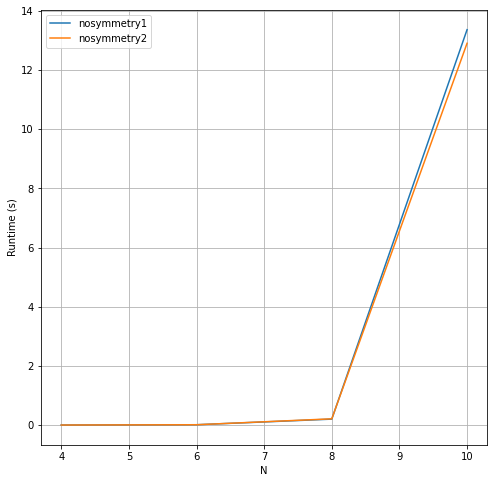

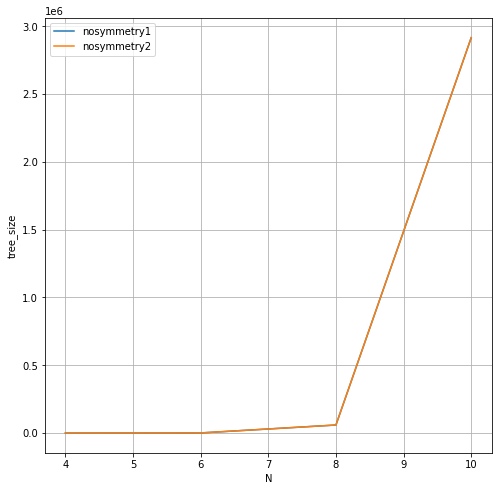

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(N, runtime['nosymmetry1'], label='nosymmetry1')
plt.plot(N, runtime['nosymmetry2'], label='nosymmetry2')
plt.legend()
plt.grid(True)
plt.xlabel('N')
plt.ylabel('Runtime (s)')

plt.figure(figsize=(8, 8))
plt.plot(N, tree_size['nosymmetry1'], label='nosymmetry1')
plt.plot(N, tree_size['nosymmetry2'], label='nosymmetry2')
plt.legend()
plt.grid(True)
plt.xlabel('N')
plt.ylabel('tree_size')

## 4. Randomisation and Restarts

**Exercice:** Declare two search strategies: one that uses a lexicographical order on both variables and values, 
and the other using an impact-based choice on the variables with a random value selection.

In [15]:
from docplex.cp.parameters import CpoParameters


def run(model: CpoModel, params: CpoParameters):
    sol = model.solve(TimeLimit=params.TimeLimit, SearchType=params.SearchType)
    return([sol.get_solver_infos()['NumberOfChoicePoints'], sol.get_solver_infos()['TotalTime'], sol.get_solver_infos()['SearchStatus']])

In [16]:
N = [4, 6, 8, 10]

runtime_strat1 = []
runtime_strat2 = []

tree_size_strat1 = []
tree_size_strat2 = []

for n in N:
    print(n)
    mdl = nosymmetry2_optimisation_model(n)
    SearchPhase = mdl.search_phase(mdl.get_all_variables(),
                                   varchooser=mdl.select_smallest(
                                       mdl.var_index(mdl.get_all_variables())),
                                   valuechooser=mdl.select_smallest(mdl.value_index(range(n))))

    mdl.add_search_phase(SearchPhase)
    res = run(mdl, CpoParameters(TimeLimit=10,
                                 LogPeriod=100000, SearchType='DepthFirst'))
    runtime_strat1 += [res[1]]
    tree_size_strat1 += [res[0]]

    mdl2 = nosymmetry2_optimisation_model(n)
    SearchPhase = mdl2.search_phase(mdl2.get_all_variables(),
                                    varchooser=mdl2.select_smallest(
                                        mdl.var_impact()),
                                    valuechooser=mdl2.select_random_value())

    mdl2.add_search_phase(SearchPhase)

    res = run(mdl2, CpoParameters(TimeLimit=10,
                                  LogPeriod=100000, SearchType='DepthFirst'))
    runtime_strat2 += [res[1]]
    tree_size_strat2 += [res[0]]

4
6
8
10



**Exercice:** Run the two strategies using the `nosymmetry2_optimisation_model` for different values of $n$.

Text(0.5, 1.0, 'Tree_size for the 2 search strategies')

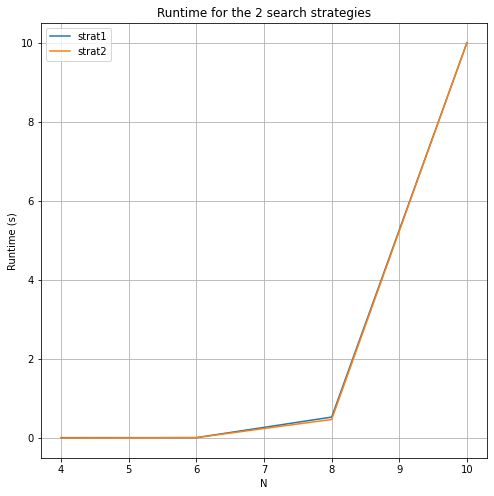

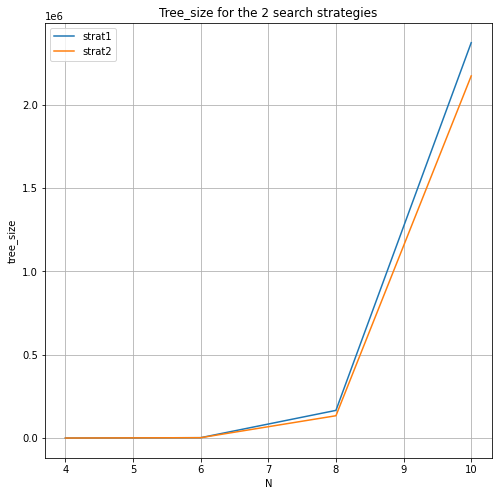

In [17]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 8))
plt.plot(N, runtime_strat1, label='strat1')
plt.plot(N, runtime_strat2, label='strat2')
plt.legend()
plt.grid(True)
plt.xlabel('N')
plt.ylabel('Runtime (s)')
plt.title('Runtime for the 2 search strategies')


plt.figure(figsize=(8, 8))
plt.plot(N, tree_size_strat1, label='strat1')
plt.plot(N, tree_size_strat2, label='strat2')
plt.legend()
plt.grid(True)
plt.xlabel('N')
plt.ylabel('tree_size')
plt.title('Tree_size for the 2 search strategies')

Combinatorial search exhibits usually a bad behaviour in the runtime distribution called **heavy tailed phenomenon**. 
That is, at any node of the search tree, there is a non-negligeable probability that the time needed to explore the current subtree is heavier than 
an exponential distribution (you can read about it here https://aaai.org/Papers/AAAI/1998/AAAI98-061.pdf. 


A simple solution to deal with such a bad behaviour is to restart search from time to time. 
CPOptimizer offers this choice by using the parameter: 
    
```python
SearchType="Restart"
```

**Exercice:** Using a restart search, evaluate the two strategies mentionned above using the `nosymmetry2_optimisation_model` for different values of $n$. What can you conclude?

In [18]:
N = [4, 6, 8, 10]

runtime_strat1 = []
runtime_strat2 = []

tree_size_strat1 = []
tree_size_strat2 = []

for n in N:

    mdl = nosymmetry2_optimisation_model(n)
    SearchPhase = mdl.search_phase(mdl.get_all_variables(),
                                   varchooser=mdl.select_smallest(
                                       mdl.var_index(mdl.get_all_variables())),
                                   valuechooser=mdl.select_smallest(mdl.value_index(range(n))))

    mdl.add_search_phase(SearchPhase)
    res = run(mdl, CpoParameters(
        TimeLimit=5, LogPeriod=100000, SearchType="Restart"))
    runtime_strat1 += [res[1]]
    tree_size_strat1 += [res[0]]

    mdl = nosymmetry2_optimisation_model(n)
    SearchPhase = mdl.search_phase(mdl.get_all_variables(),
                                   varchooser=mdl.select_smallest(
                                       mdl.var_impact()),
                                   valuechooser=mdl.select_random_value())

    mdl.add_search_phase(SearchPhase)

    res = run(mdl, CpoParameters(
        TimeLimit=5, LogPeriod=100000, SearchType="Restart"))
    runtime_strat2 += [res[1]]
    tree_size_strat2 += [res[0]]

Text(0.5, 1.0, 'Tree_size for the 2 search strategies with SearchType = Restart')

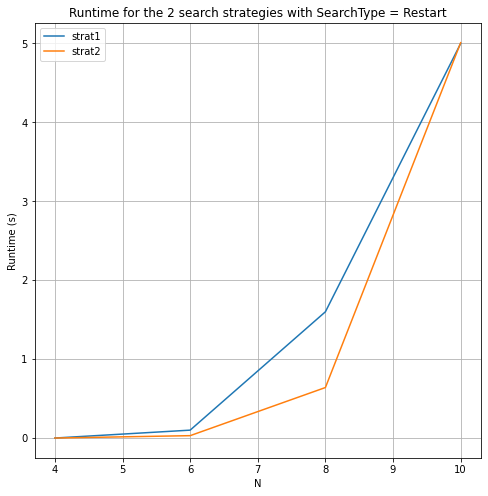

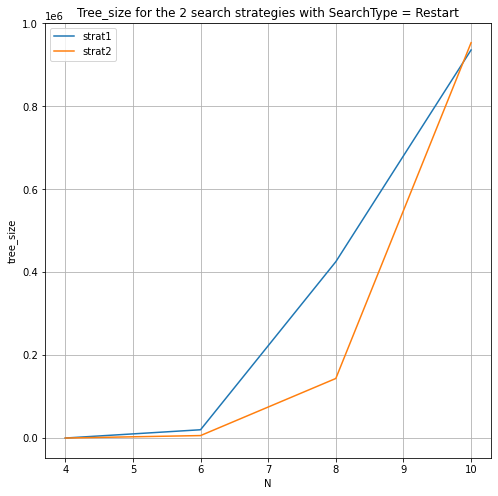

In [19]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 8))
plt.plot(N, runtime_strat1, label='strat1')
plt.plot(N, runtime_strat2, label='strat2')
plt.legend()
plt.grid(True)
plt.xlabel('N')
plt.ylabel('Runtime (s)')
plt.title('Runtime for the 2 search strategies with SearchType = Restart')


plt.figure(figsize=(8, 8))
plt.plot(N, tree_size_strat1, label='strat1')
plt.plot(N, tree_size_strat2, label='strat2')
plt.legend()
plt.grid(True)
plt.xlabel('N')
plt.ylabel('tree_size')
plt.title('Tree_size for the 2 search strategies with SearchType = Restart')

**Exercice:** What is the maximum value of $n$ for which you can solve this problem? Use all your techniques! 

## 5. Conclusion

**Question:** What did you learn today? 

First of all, it is very important to remove the symmetries of the problem so that there are less solutions to find and thus the solver takes less time to run. In this Golomb Ruler problem, we break symmetries by forcing some variables to take specific values:
- marks[0]==0 : force the first mark to be 0
- mdl.add(abs_of(marks[1]-marks[0])<abs_of(marks[n-1]-marks[n-2])) : force the first interval to be smaller than the last one to avoid another symmetry
-for i in range(1,n):
        mdl.add(marks[i-1]<marks[i]) : force the marks to be in an ascending order to avoid a third symmetry
        
We also add implied constraints but for this problem it seems that they did not have a noticeable impact. For exemple, in our problem, 'mdl.add(all_diff(marks))' can be added as an implied constraint of 'mdl.add(mdl.all_diff([abs_of(mark[0]-mark[1]) for mark in list(combinations(marks,2))]))'.


Moreover, we did not notice a huge difference between the 2 branching strategies (see figures 'Runtime for the 2 search strategies with SearchType = Restart' and 'Tree_size for the 2 search strategies with SearchType = Restart', which was not the case in the previous tutorial. We did not clearly understand why there are no big differences between the 2 branching strategies knowing that the 2nd branching strategy is a randomisation of the values.

<div class="alert alert-block alert-danger"></div>